In [1]:
%load_ext autoreload
%autoreload 2

import os

img_dir = "img/gaussfilter/"
if not os.path.isdir(img_dir):
    os.makedirs(img_dir)

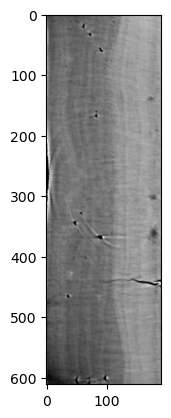

In [2]:
"""
Read in a straightened image

"""
import numpy as np
import matplotlib.pyplot as plt

image = np.load("cropped_image.npy")
plt.imshow(image, cmap="grey")

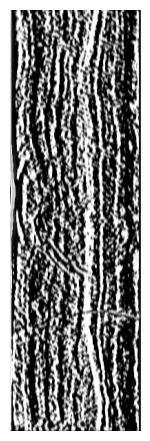

In [3]:
"""
Apply a steerable Gaussian filter to it

"""
from cementum import filter

sigma = 1.5

filtered = filter.steerable_filter(image, theta=0, sigma=sigma)

fig, axis = plt.subplots()
axis.imshow(filtered, cmap="grey")

fig.tight_layout()
axis.set_axis_off()

fig.savefig(f"{img_dir}/single_filter.png", bbox_inches="tight")

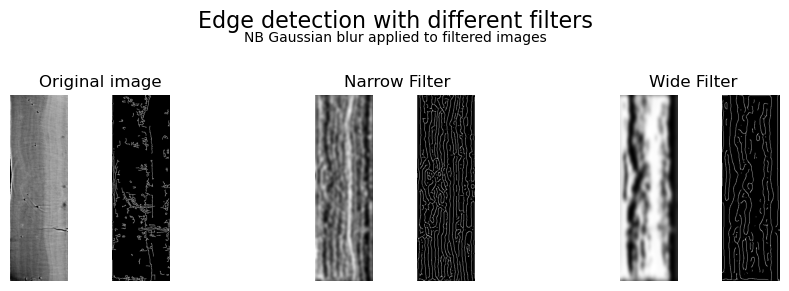

In [4]:
"""
Why do we want to use a filter? Apply Canny edge detection to the image before and after filtering to illustrate

"""
from skimage import filters
from skimage import feature as skfeature

# Filter an image with a wide filter
sigma = 1.5
narrow_filtered = filter.steerable_filter(image, theta=0, sigma=sigma)
wide_filtered = filter.steerable_filter(image, theta=0, sigma=5 * sigma)
images = [image, narrow_filtered, wide_filtered]

# Blur the images a bit since edge detection is sensitive to noise
blur_sigma = 5
images[1:] = [filters.gaussian(img, sigma=blur_sigma) for img in images[1:]]

# Find edges
edges = [skfeature.canny(img) for img in images]


fig, axes = plt.subplot_mosaic(
    """
    AB.CD.EF
    AB.CD.EF
    AB.CD.EF
    """,
    figsize=(8, 12),
)

img_axes = [axes[l] for l in "ACE"]
edge_axes = [axes[l] for l in "BDF"]

for img_axis, edge_axis, img, edge in zip(img_axes, edge_axes, images, edges):
    img_axis.imshow(img, cmap="grey")
    edge_axis.imshow(edge, cmap="grey")

    img_axis.set_axis_off()
    edge_axis.set_axis_off()

fig.suptitle("Edge detection with different filters", fontsize=16)
fig.text(
    0.5,
    0.953,
    "NB Gaussian blur applied to filtered images",
    fontsize=10,
    ha="center",
)

axes["A"].set_title("Original image", ha="left")
axes["C"].set_title("Narrow Filter", ha="left")
axes["E"].set_title("Wide Filter", ha="left")


fig.tight_layout()
plt.subplots_adjust(top=1.65)

fig.savefig(f"{img_dir}/edge_detection.png", bbox_inches="tight")

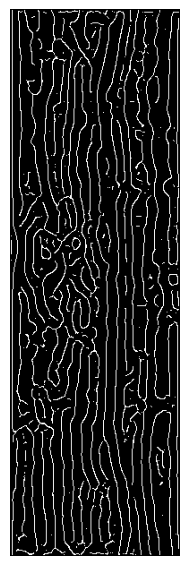

In [5]:
fig, axis = plt.subplots(figsize=(2, 6))

axis.imshow(edges[1] * 255, cmap="grey")
axis.set_axis_off()

fig.tight_layout()
fig.savefig(f"{img_dir}/edge_detection_single.png", bbox_inches="tight")

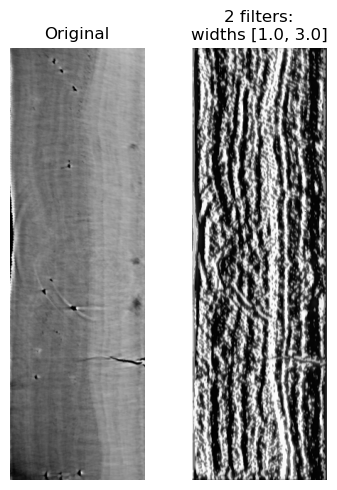

In [6]:
"""
Apply the average of multiple filters to it

"""
import os

filters = [1.0, 3.0]
multi_filtered = filter.apply_weighted_filters(image, widths=filters)

fig, axes = plt.subplots(1, 2, figsize=(4, 5))

axes[0].imshow(image, cmap="grey")
axes[1].imshow(multi_filtered, cmap="grey")

axes[0].set_title("Original")
axes[1].set_title(f"{len(filters)} filters:\nwidths {filters}")

for axis in axes:
    axis.axis("off")

fig.tight_layout()

img_dir = "img/gaussfilter"
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

fig.savefig(f"{img_dir}/multi_filter.png", bbox_inches="tight")

What do we want this filter to do?
- Improve contrast between layers

What do we want it to avoid?
- s

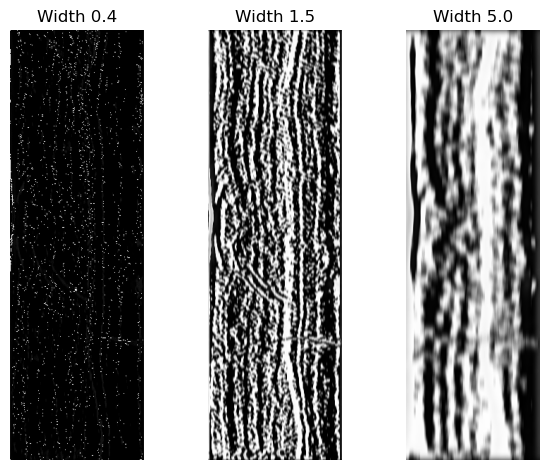

In [7]:
"""
Plot narrow and wide filters

"""
fig, axes = plt.subplots(1, 3)
min_width, max_width = 0.4, 5.0
widths = [min_width, 1.5, max_width]

# Show the

# Show the images
for width, axis in zip(widths, axes):
    axis.set_title(f"Width {width}")
    axis.imshow(filter.steerable_filter(image, theta=0, sigma=width), cmap="grey")
    axis.set_axis_off()

fig.tight_layout()
fig.savefig(f"{img_dir}/filter_widths.png", bbox_inches="tight")

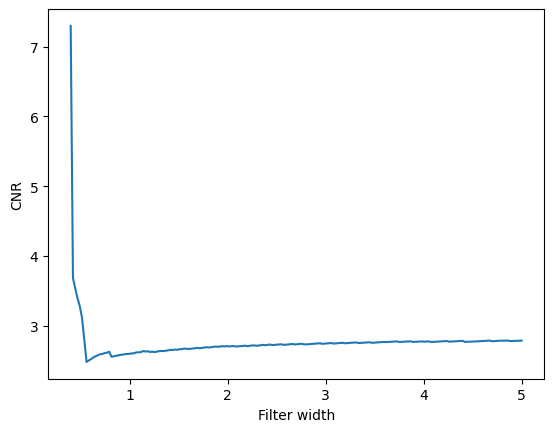

In [8]:
def calculate_cnr(image):
    # Calculate the contrast and noise in the image
    contrast = image.max() - image.min()
    noise = image.std()
    return contrast / noise


# Calculate the CNR for different filter widths
widths = np.linspace(min_width, max_width, 200)
cnrs = []

for width in widths:
    filtered = filter.steerable_filter(image, theta=0, sigma=width)
    cnr = calculate_cnr(filtered)
    cnrs.append(cnr)

# Plot the CNR as a function of filter width
plt.plot(widths, cnrs)
plt.xlabel("Filter width")
plt.ylabel("CNR")
plt.show()

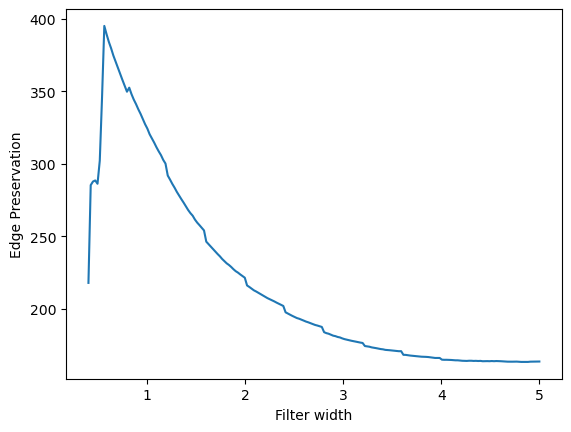

In [9]:
import numpy as np
from scipy.ndimage import sobel


def calculate_edge_preservation(original, filtered):
    # Calculate the gradient of the original and filtered images
    original_gradient = np.hypot(sobel(original, 0), sobel(original, 1))
    filtered_gradient = np.hypot(sobel(filtered, 0), sobel(filtered, 1))

    # Calculate the difference between the two gradients
    difference = np.abs(original_gradient - filtered_gradient)

    # Return the mean difference (lower values indicate better edge preservation)
    return difference.mean()


# Calculate the edge preservation for different filter widths
edge_preservations = []

for width in widths:
    filtered = filter.steerable_filter(image, theta=0, sigma=width)
    edge_preservation = calculate_edge_preservation(image, filtered)
    edge_preservations.append(edge_preservation)

# Plot the edge preservation as a function of filter width
plt.plot(widths, edge_preservations)
plt.xlabel("Filter width")
plt.ylabel("Edge Preservation")
plt.show()

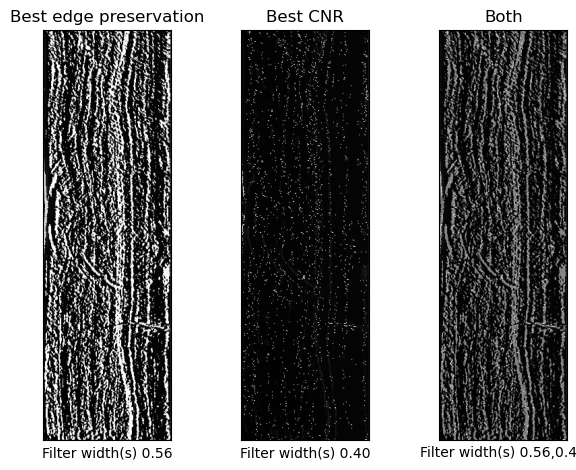

In [10]:
"""
Let's look at these two filters, and their combination

"""
edge_preservations = np.array(edge_preservations)
cnrs = np.array(cnrs)

max_edge_preservation = widths[np.argmax(edge_preservations)]
max_cnr = widths[np.argmax(cnrs)]

fig, axes = plt.subplots(1, 3)

for width, axis, title in zip(
    ([max_edge_preservation], [max_cnr], [max_edge_preservation, max_cnr]),
    axes,
    ["Best edge preservation", "Best CNR", "Both"],
):
    axis.imshow(filter.apply_weighted_filters(image, widths=width), cmap="grey")

    # Plot title describing the filters
    axis.set_title(title)

    # Label x axis with filter widths
    label = "Filter width(s) "
    for w in width:
        label += f"{w:.2f},"
    axis.set_xlabel(label[:-1])

    axis.set_yticks([])
    axis.set_xticks([])


fig.tight_layout()

Text(0.5, 0.98, 'Value greater than 0.56 indicates bimodality')

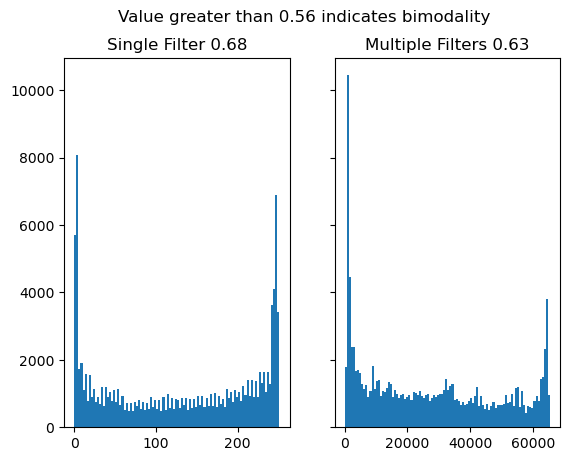

In [11]:
"""
Plot histograms and indicate the interquartile range

"""
from scipy import stats


def bimodality_coefficient(x):
    g1 = stats.skew(x)
    g2 = stats.kurtosis(x)

    n = len(x)
    return (g1**2 + 1) / (g2 + 3 * (n - 1) ** 2 / ((n - 2) * (n - 3)))


fig, axes = plt.subplots(1, 2, sharey=True)

axes[0].hist(filtered.flat, bins=100)
axes[0].set_title(f"Single Filter {bimodality_coefficient(filtered.flat):.2f}")

axes[1].hist(multi_filtered.flat, bins=100)
axes[1].set_title(f"Multiple Filters {bimodality_coefficient(multi_filtered.flat):.2f}")

fig.suptitle(f"Value greater than {5/9:.2f} indicates bimodality")

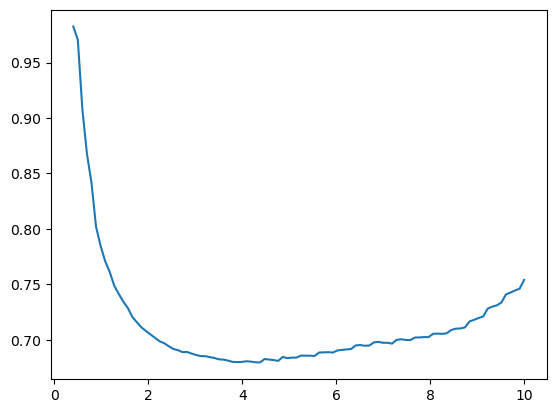

In [12]:
"""
Run many single filters, record the bimodality coefficient for each

"""
n = 100
widths = np.linspace(0.4, 10, n)
coeffs = np.full(n, np.nan)

for i, width in enumerate(widths):
    filtered = filter.apply_weighted_filters(image, widths=[width])
    coeffs[i] = bimodality_coefficient(filtered.flat)

plt.plot(widths, coeffs)